<a href="https://colab.research.google.com/github/takiyama0617/colaboratory/blob/master/Sample_TensorFlow%2BKeras%2BMNIST_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kerasとは
複数のバックエンドの深層学習フレームワークで共通なPythonプログラミング手法を提供するニューラルネットワークライブラリのラッパー


## Kerasのバックエンドエンジン
Kerasのバックエンドエンジン（深層学習フレームワーク）として、以下の３つに接続出来る。
* TensorFlow
 * Google製。人気あるみたい。
* Theano
 * カナダのどっかの大学が主導している。
* CNTK
 * Microsoft製。

## Kerasを用いた処理フロー
1. データを用意する
 1. データロード
 1. 前処理
1. モデルを構築する
 1. モデルを定義する
 1. モデルにレイヤーを追加
1. 学習する
1. 検証・評価する

In [37]:
!pip install tensorflow

In [38]:
import tensorflow as tf

print(tf.__version__)

1.15.0


In [39]:
!pip install keras

In [40]:
import keras

print(keras.__version__)

2.2.5


In [0]:
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 10
IMG_ROWS, IMG_COLS = 28, 28

In [0]:
handwritten_number_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [43]:
from keras.datasets import mnist

(train_data, train_teacher_labels), (test_data, test_teacher_labels) = mnist.load_data()

print('ロードしたあとの学習データ train_data shape : ', train_data.shape)
print('ロードしたあとの検証データ test_data shape : ', test_data.shape)

ロードしたあとの学習データ train_data shape :  (60000, 28, 28)
ロードしたあとの検証データ test_data shape :  (10000, 28, 28)


* **学習データ**：学習フェーズで使用するデータ。データセットの７割、８割を学習データとして使うのが一般的。
* **検証データ**：学習後、学習済みモデルの性能をテストするためのデータ。データセットの学習データ以外の２割、３割のデータを使うのが一般的。

## 学習モデルに合わせたデータ配列の形状変換とデータ調整

In [44]:
from keras import backend as Keras

print('Channel調節変換前 train_data shape : ', train_data.shape)
print('Channel調節変換前 test_data shape : ', test_data.shape)

if Keras.image_data_format() == 'channels_first' :
  train_data = train_data.reshape(train_data.shape[0], 1, IMG_ROWS, IMG_COLS)
  test_data = test_data.reshape(test_data.shape[0], 1, IMG_ROWS, IMG_COLS)
  input_shape = (1, IMG_ROWS, IMG_COLS)
else :
  train_data = train_data.reshape(train_data.shape[0], IMG_ROWS, IMG_COLS, 1)
  test_data = test_data.reshape(test_data.shape[0], IMG_ROWS, IMG_COLS, 1)
  input_shape = (IMG_ROWS, IMG_COLS, 1)

print('Channel調節変換後 train_data shape : ', train_data.shape)
print('Channel調節変換後 test_data shape : ', test_data.shape)


Channel調節変換前 train_data shape :  (60000, 28, 28)
Channel調節変換前 test_data shape :  (10000, 28, 28)
Channel調節変換後 train_data shape :  (60000, 28, 28, 1)
Channel調節変換後 test_data shape :  (10000, 28, 28, 1)


In [45]:
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

print(test_data)

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.

In [46]:
train_data /= 255
test_data /= 255

print('学習データ　train_data shape : ', train_data.shape)
print(train_data.shape[0], 'サンプルを学習します')
print('検証データ　test_data shape : ', test_data.shape)
print(test_data.shape[0], 'サンプルを検証します')

学習データ　train_data shape :  (60000, 28, 28, 1)
60000 サンプルを学習します
検証データ　test_data shape :  (10000, 28, 28, 1)
10000 サンプルを検証します


## 教師ラベルデータの変換
* Kerasで分類を行う際は、教師ラベルをOne-hotベクトル（1-of-k表現）変換する必要がある
  * 学習プロセスのmodel.fit()に渡すデータのフォーマットに合わせるため

In [47]:
# 学習用教師ラベルデータをOne-hotベクトルに変換
print('Keras変換前学習用教師ラベルデータ　train_teacher_labels shape : ', train_teacher_labels.shape)
train_teacher_labels = keras.utils.to_categorical(train_teacher_labels, NUM_CLASSES)
print('Keras変換後学習用教師ラベルデータ　train_teacher_labels shape : ', train_teacher_labels.shape)

# 検証用教師ラベルデータをOne-hotベクトルに変換
print('Keras変換前検証用教師ラベルデータ　test_teacher_labels shape : ', test_teacher_labels.shape)
print(test_teacher_labels)
test_teacher_labels = keras.utils.to_categorical(test_teacher_labels, NUM_CLASSES)
print('Keras変換後検証用教師ラベルデータ　test_teacher_labels shape : ', test_teacher_labels.shape)
print(test_teacher_labels)

Keras変換前学習用教師ラベルデータ　train_teacher_labels shape :  (60000,)
Keras変換後学習用教師ラベルデータ　train_teacher_labels shape :  (60000, 10)
Keras変換前検証用教師ラベルデータ　test_teacher_labels shape :  (10000,)
[7 2 1 ... 4 5 6]
Keras変換後検証用教師ラベルデータ　test_teacher_labels shape :  (10000, 10)
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## ニューラルネットワークのモデルの構築

### シーケンシャルモデル指定

In [0]:
from keras.models import Sequential

model = Sequential()

In [0]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

### ニューラルネットワークの構築

In [50]:
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

### モデルのコンパイル
どのような学習処理を行うか以下の設定が必要
* 最適化アルゴリズム
* 損失関数
* 評価関数のリスト

In [0]:
model.compile(optimizer=keras.optimizers.Adadelta(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

## 学習

In [0]:
import matplotlib.pyplot as plt


def plot_loss_accuracy_graph(fir_record) :
  plt.plot(fit_record.history['loss'], "-D", color="blue", label="train_loss", linewidth=2)
  plt.plot(fit_record.history['val_loss'], "-D", color="black", label="val_loss", linewidth=2)
  plt.title('LOSS')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")
  plt.show()

  plt.plot(fit_record.history['acc'], "-o", color="green", label="train_accuracy", linewidth=2)
  plt.plot(fit_record.history['val_acc'], "-D", color="black", label="val_accuracy", linewidth=2)
  plt.title('ACCURACY')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.show()



In [53]:
print('反復学習回数 : ', EPOCHS)
fit_record = model.fit(train_data,
                       train_teacher_labels,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       verbose=1,
                       validation_data=(test_data, test_teacher_labels)
                       )

反復学習回数 :  10
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.2641 - acc: 0.9187 - val_loss: 0.0592 - val_acc: 0.9808
Epoch 2/10
60000/60000 [==============================] - 4s 62us/step - loss: 0.0884 - acc: 0.9737 - val_loss: 0.0391 - val_acc: 0.9866
Epoch 3/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.0652 - acc: 0.9803 - val_loss: 0.0362 - val_acc: 0.9874
Epoch 4/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.0535 - acc: 0.9833 - val_loss: 0.0305 - val_acc: 0.9892
Epoch 5/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.0471 - acc: 0.9860 - val_loss: 0.0290 - val_acc: 0.9897
Epoch 6/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.0411 - acc: 0.9878 - val_loss: 0.0303 - val_acc: 0.9893
Epoch 7/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.0365 - acc: 0.9890 - val_loss: 0.0

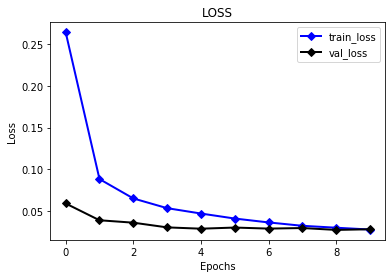

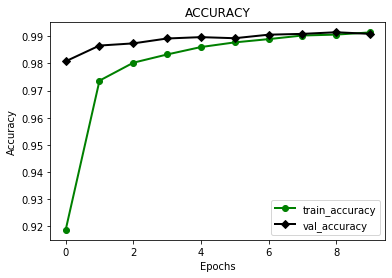

In [54]:
plot_loss_accuracy_graph(fit_record)

## 検証

In [0]:
result_score = model.evaluate(test_data, test_teacher_labels, verbose=0)

In [56]:
print('検証誤差 : ', result_score[0])
print('検証正解率 : ', result_score[1])

検証誤差 :  0.028292698908401324
検証正解率 :  0.9909


## 予測

In [0]:
predictions_array = model.predict(test_data)

In [0]:
import numpy as np

def plot_image(data_location, predictions_array, real_teacher_labels, dataset) :
  predictions_array, real_teacher_labels, img = predictions_array[data_location], real_teacher_labels[data_location], dataset[data_location]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == real_teacher_labels :
    color = 'green'
  else :
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(
      handwritten_number_names[predicted_label],
      100 * np.max(predictions_array),
      handwritten_number_names[real_teacher_labels]),
      color=color)



In [0]:
def plot_teacher_labels_graph(data_location, predictions_array, real_teacher_labels) :
  predictions_array, real_teacher_labels = predictions_array[data_location], real_teacher_labels[data_location]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  thisplot = plt.bar(range(10), predictions_array, color="#666666")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[real_teacher_labels].set_color('green')

In [0]:
def convertOneHotVector2Integers(one_hot_vector) :
  return [np.where(r == 1)[0][0] for r in one_hot_vector]

In [66]:
print(test_teacher_labels)
print(convertOneHotVector2Integers(test_teacher_labels))

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 

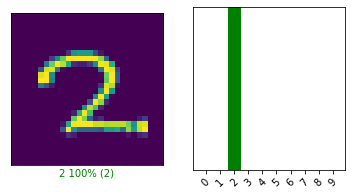

In [73]:
# 描画の為に検証データを変換
test_data = test_data.reshape(test_data.shape[0], IMG_ROWS, IMG_COLS)

data_location = 77
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plot_image(
    data_location, 
    predictions_array, 
    convertOneHotVector2Integers(test_teacher_labels), 
    test_data)

plt.subplot(1, 2, 2)
plot_teacher_labels_graph(
    data_location,
    predictions_array,
    convertOneHotVector2Integers(test_teacher_labels))

_ = plt.xticks(range(10), handwritten_number_names, rotation=45)


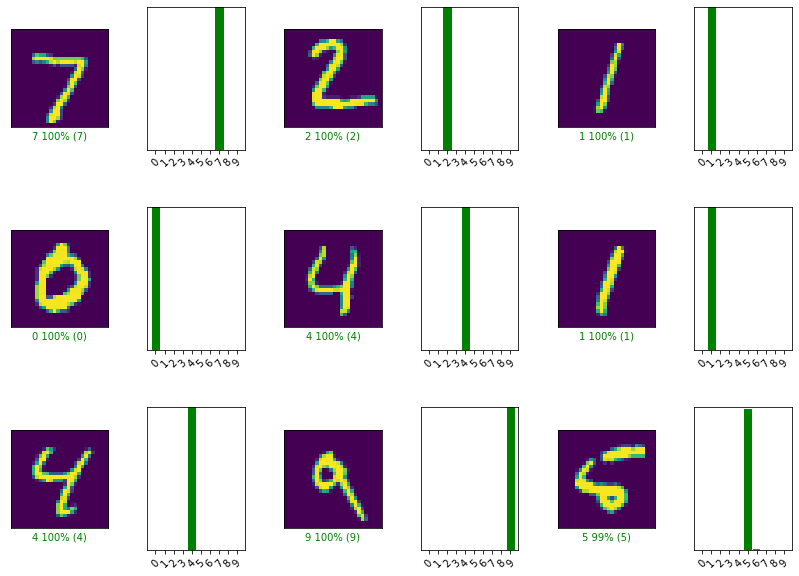

In [77]:
NUM_ROWS = 3
NUM_COLS = 3
NUM_IMAGES = NUM_ROWS * NUM_COLS

plt.figure(figsize=(2 * 2 * NUM_COLS + 2, 2 * NUM_ROWS + 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(NUM_IMAGES) :
  plt.subplot(NUM_ROWS, 2 * NUM_COLS, 2 * i + 1)
  plot_image(
      i,
      predictions_array,
      convertOneHotVector2Integers(test_teacher_labels),
      test_data
  )

  plt.subplot(NUM_ROWS, 2 * NUM_COLS, 2 * i + 2)
  plot_teacher_labels_graph(
      i,
      predictions_array,
      convertOneHotVector2Integers(test_teacher_labels)
  )

  _ = plt.xticks(range(10), handwritten_number_names, rotation=45)

(28, 28)


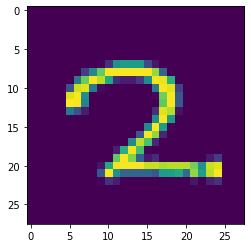

In [79]:
img = test_data[data_location]
print(img.shape)
plt.imshow(img)

In [80]:
img = (np.expand_dims(img, 0))
img = img.reshape(1, IMG_ROWS, IMG_COLS, 1)
print(img.shape)

(1, 28, 28, 1)


In [82]:
predictions_result_array = model.predict(img)
print(predictions_result_array)
number = np.argmax(predictions_result_array[0])
print('予測結果 : ', handwritten_number_names[number])

[[2.3375456e-08 1.1387551e-08 9.9999976e-01 9.0472012e-11 7.5762192e-12
  2.6206296e-12 1.6172491e-10 2.6243674e-07 9.0213801e-09 1.1450206e-09]]
予測結果 :  2


## 学習済みモデルの保存

In [0]:
model.save('keras-mnist-model.h5')

In [84]:
ls

keras-mnist-model.h5  sample_data/
